# Topología de Datos: Estrategias de Visualización

## Introducción

La **topología de datos** estudia la estructura y forma de los datos en espacios de alta dimensión. A diferencia del análisis topológico de datos (TDA) que se enfoca en homología persistente, nos concentraremos en técnicas de visualización que preservan propiedades topológicas.

### ¿Por qué es importante?
- Los datos reales a menudo están distribuidos en variedades (manifolds) de dimensión menor que el espacio ambiente
- Las técnicas de visualización nos permiten revelar la estructura topológica subyacente
- Cada técnica preserva diferentes aspectos de la topología original

### Técnicas que exploraremos:
1. **t-SNE** (t-distributed Stochastic Neighbor Embedding)
2. **UMAP** (Uniform Manifold Approximation and Projection)
3. **Isomap** (Isometric Mapping)
4. **PHATE** (Potential of Heat-diffusion for Affinity-based Transition Embedding)

In [1]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Técnicas de reducción de dimensionalidad
from sklearn.manifold import TSNE, Isomap
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
import umap
import phate

# Métricas y utilidades
from sklearn.metrics import adjusted_rand_score, silhouette_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
np.random.seed(42)

## Dataset: Dígitos Escritos a Mano

Usaremos el dataset de dígitos de sklearn que contiene:
- 1797 imágenes de 8x8 píxeles (64 dimensiones)
- 10 clases (dígitos 0-9)
- Perfecto para demostrar cómo las técnicas preservan la estructura de clases

In [2]:
# Cargar el dataset
digits = load_digits()
X, y = digits.data, digits.target

print(f"Forma de los datos: {X.shape}")
print(f"Número de clases: {len(np.unique(y))}")
print(f"Clases: {np.unique(y)}")

# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nRango original: [{X.min():.2f}, {X.max():.2f}]")
print(f"Rango normalizado: [{X_scaled.min():.2f}, {X_scaled.max():.2f}]")

Forma de los datos: (1797, 64)
Número de clases: 10
Clases: [0 1 2 3 4 5 6 7 8 9]

Rango original: [0.00, 16.00]
Rango normalizado: [-3.01, 42.38]


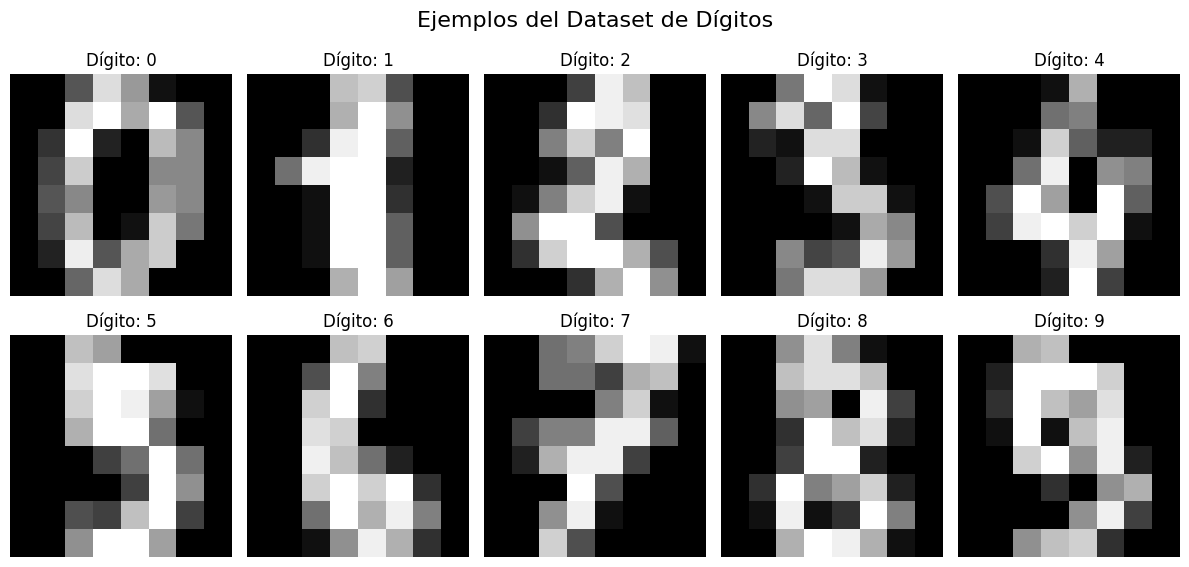

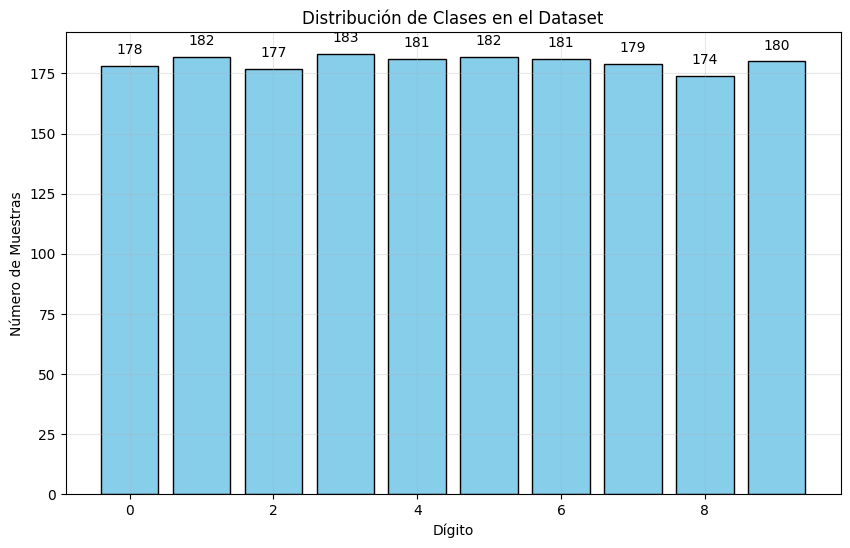

In [3]:
# Visualizar algunas muestras del dataset
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle('Ejemplos del Dataset de Dígitos', fontsize=16)

for i in range(10):
    ax = axes[i//5, i%5]
    # Encontrar el primer ejemplo de cada dígito
    idx = np.where(y == i)[0][0]
    ax.imshow(digits.images[idx], cmap='gray')
    ax.set_title(f'Dígito: {i}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Distribución de clases
plt.figure(figsize=(10, 6))
unique, counts = np.unique(y, return_counts=True)
plt.bar(unique, counts, color='skyblue', edgecolor='black')
plt.title('Distribución de Clases en el Dataset')
plt.xlabel('Dígito')
plt.ylabel('Número de Muestras')
plt.grid(True, alpha=0.3)
for i, count in enumerate(counts):
    plt.text(i, count + 5, str(count), ha='center')
plt.show()

## 1. t-SNE (t-distributed Stochastic Neighbor Embedding)

### Concepto Clave:
- Preserva **relaciones de vecindad local**
- Minimiza la divergencia KL entre distribuciones de probabilidad
- Excelente para revelar clusters y estructuras locales
- **Limitación**: No preserva distancias globales

### Parámetros importantes:
- **perplexity**: controla el número de vecinos cercanos considerados
- **learning_rate**: velocidad de optimización
- **n_iter**: número de iteraciones

In [4]:
# Aplicar t-SNE con diferentes valores de perplexity
perplexities = [5, 30, 50, 100]
tsne_results = {}

print("Aplicando t-SNE con diferentes perplexities...")
for perp in tqdm(perplexities):
    tsne = TSNE(
        n_components=2,
        perplexity=perp,
        learning_rate=200,
        n_iter=1000,
        random_state=42
    )
    tsne_results[perp] = tsne.fit_transform(X_scaled)

print("¡Completado!")

Aplicando t-SNE con diferentes perplexities...


100%|██████████| 4/4 [00:17<00:00,  4.50s/it]

¡Completado!


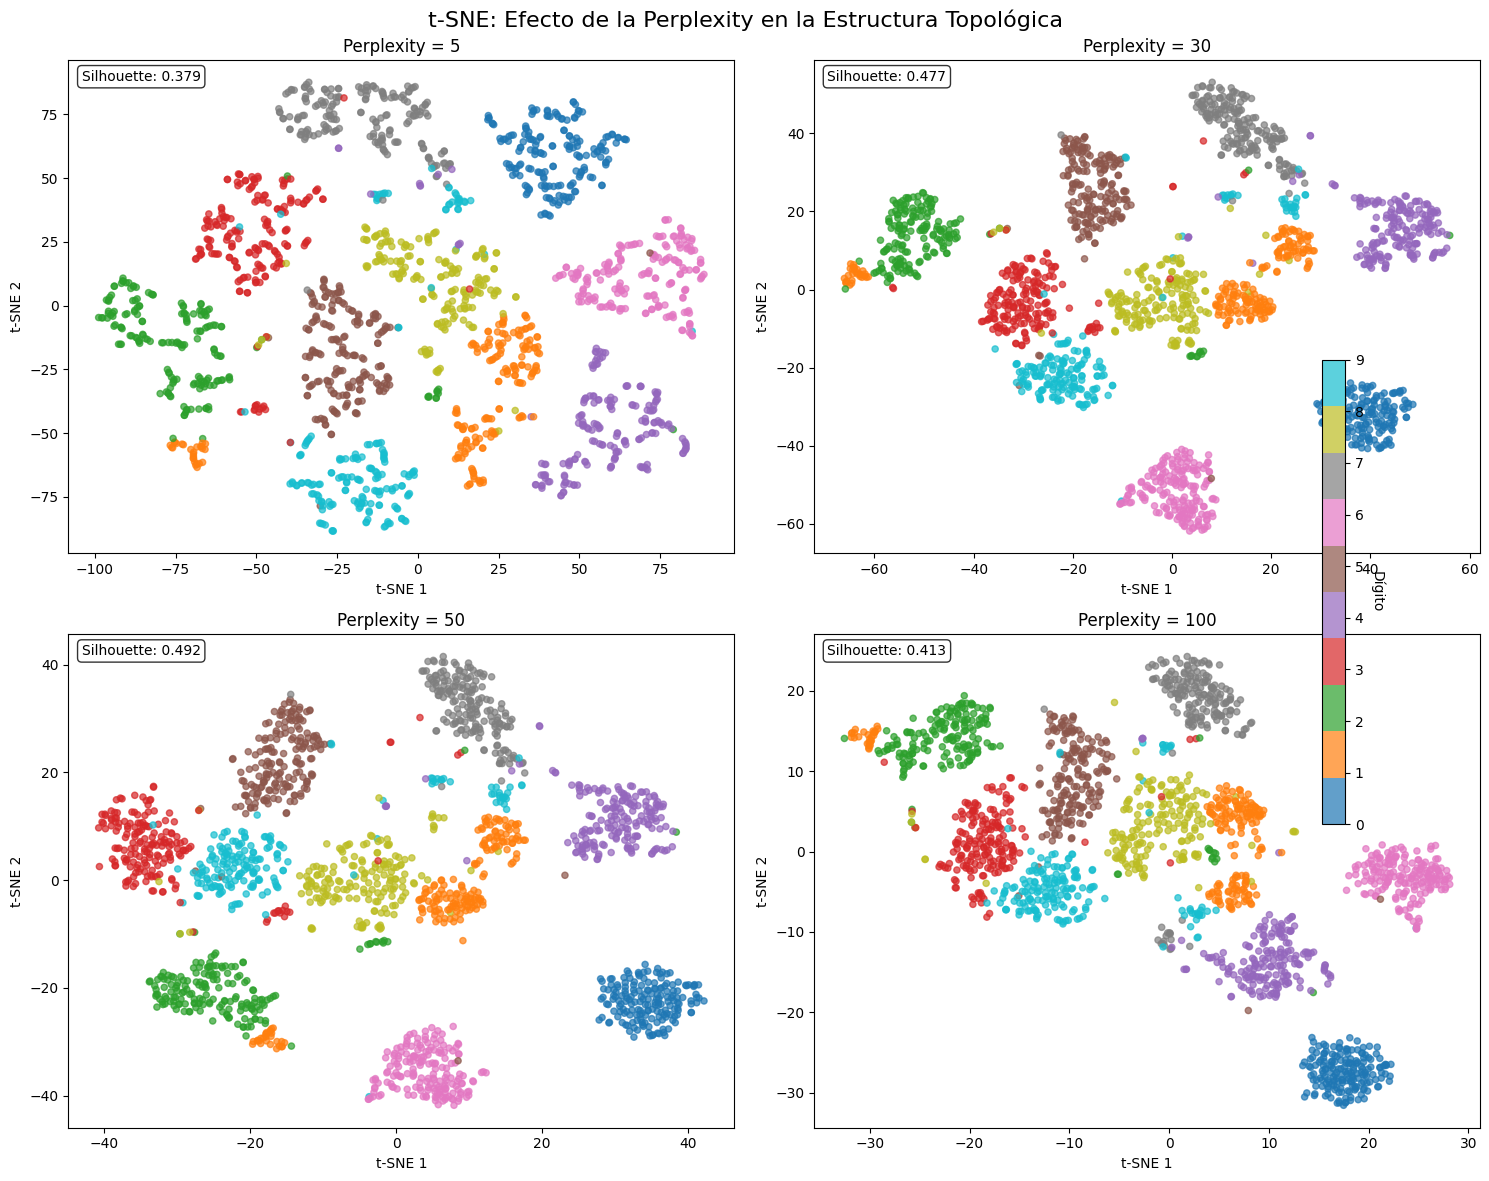

In [5]:
# Visualizar resultados de t-SNE
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('t-SNE: Efecto de la Perplexity en la Estructura Topológica', fontsize=16)

colors = plt.cm.tab10(np.linspace(0, 1, 10))

for i, perp in enumerate(perplexities):
    ax = axes[i//2, i%2]
    
    scatter = ax.scatter(
        tsne_results[perp][:, 0],
        tsne_results[perp][:, 1],
        c=y,
        cmap='tab10',
        s=20,
        alpha=0.7
    )
    
    ax.set_title(f'Perplexity = {perp}')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    
    # Calcular silhouette score
    sil_score = silhouette_score(tsne_results[perp], y)
    ax.text(0.02, 0.98, f'Silhouette: {sil_score:.3f}', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Agregar colorbar
cbar = plt.colorbar(scatter, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Dígito', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

## 2. UMAP (Uniform Manifold Approximation and Projection)

### Concepto Clave:
- Basado en **teoría de variedades de Riemann**
- Preserva tanto estructura local como global
- Más rápido que t-SNE y escalable
- Mejor preservación de la topología global

### Parámetros importantes:
- **n_neighbors**: número de vecinos para aproximación local
- **min_dist**: distancia mínima entre puntos en el embedding
- **metric**: métrica de distancia utilizada

In [6]:
# Aplicar UMAP con diferentes parámetros
n_neighbors_list = [5, 15, 30, 50]
umap_results = {}

print("Aplicando UMAP con diferentes n_neighbors...")
for n_neigh in tqdm(n_neighbors_list):
    umap_model = umap.UMAP(
        n_neighbors=n_neigh,
        min_dist=0.1,
        n_components=2,
        random_state=42
    )
    umap_results[n_neigh] = umap_model.fit_transform(X_scaled)

print("¡Completado!")

Aplicando UMAP con diferentes n_neighbors...


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]

¡Completado!


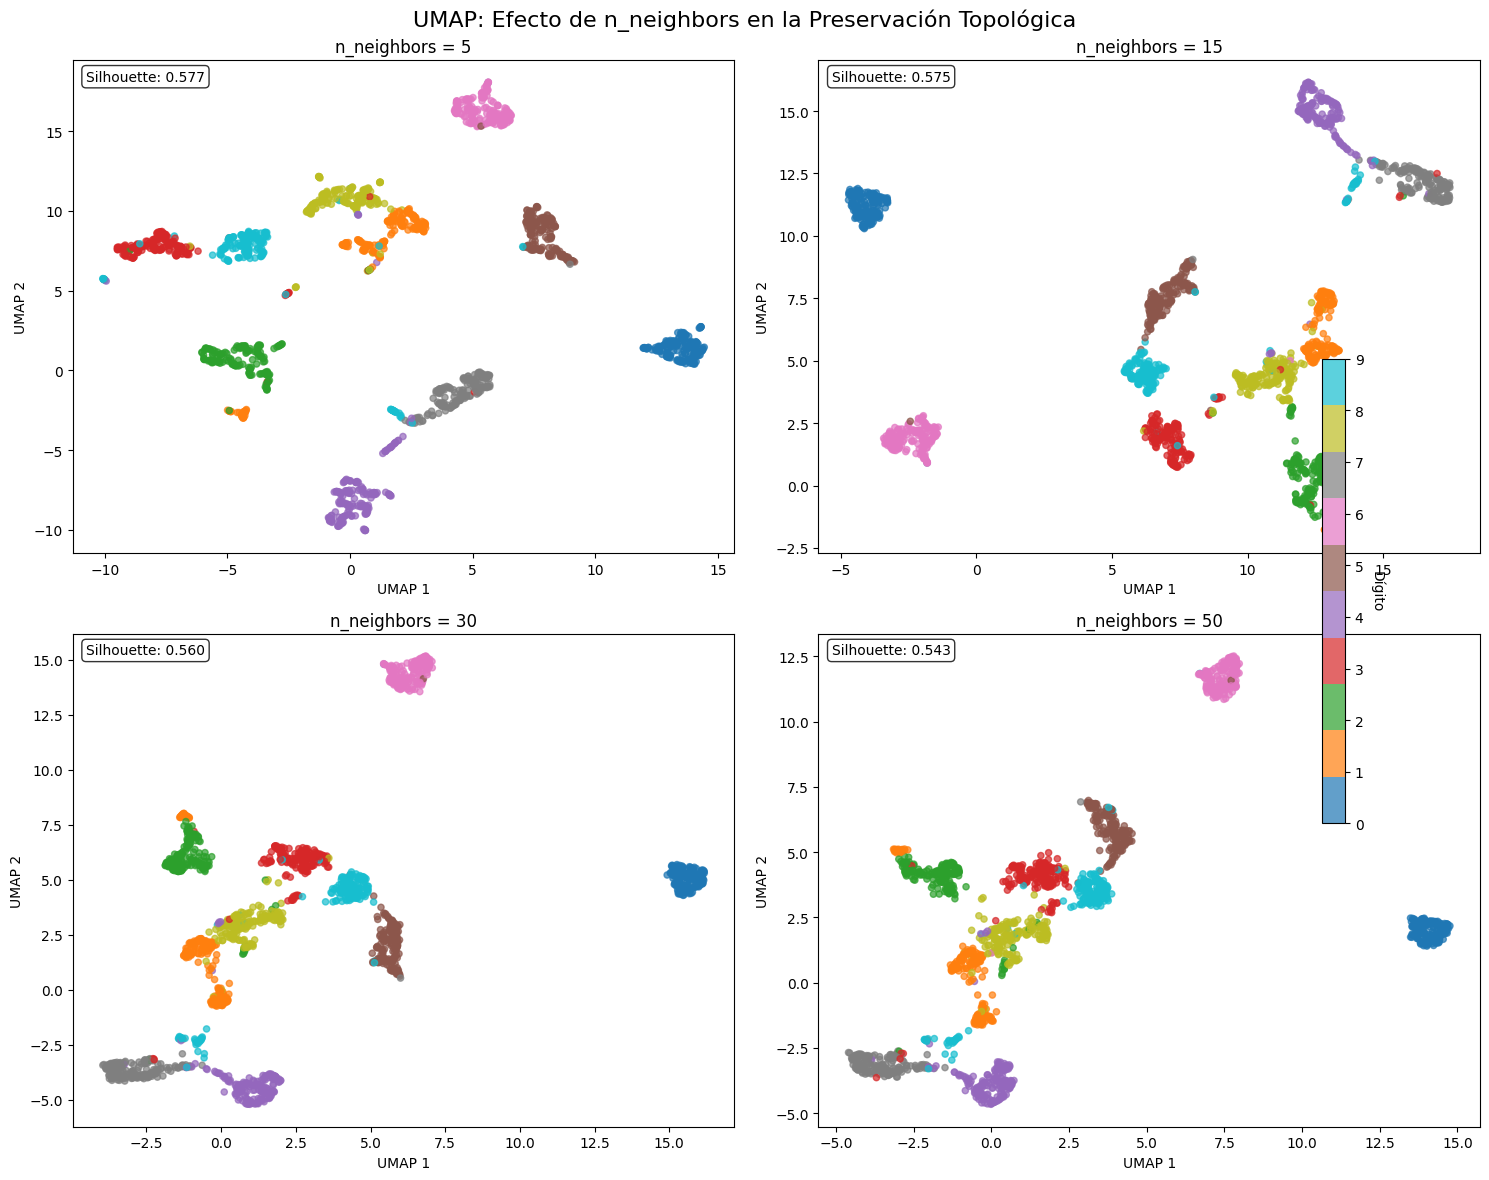

In [7]:
# Visualizar resultados de UMAP
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('UMAP: Efecto de n_neighbors en la Preservación Topológica', fontsize=16)

for i, n_neigh in enumerate(n_neighbors_list):
    ax = axes[i//2, i%2]
    
    scatter = ax.scatter(
        umap_results[n_neigh][:, 0],
        umap_results[n_neigh][:, 1],
        c=y,
        cmap='tab10',
        s=20,
        alpha=0.7
    )
    
    ax.set_title(f'n_neighbors = {n_neigh}')
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    
    # Calcular silhouette score
    sil_score = silhouette_score(umap_results[n_neigh], y)
    ax.text(0.02, 0.98, f'Silhouette: {sil_score:.3f}', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Agregar colorbar
cbar = plt.colorbar(scatter, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Dígito', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

## 3. Isomap (Isometric Mapping)

### Concepto Clave:
- Preserva **distancias geodésicas** en la variedad
- Usa grafos de vecindad para aproximar la variedad
- Aplica MDS (Multi-Dimensional Scaling) en el espacio geodésico
- Asume que los datos están en una variedad convexa

### Parámetros importantes:
- **n_neighbors**: número de vecinos para construir el grafo
- **eigen_solver**: método para calcular eigenvalores

In [8]:
# Aplicar Isomap con diferentes números de vecinos
n_neighbors_iso = [5, 10, 20, 30]
isomap_results = {}

print("Aplicando Isomap con diferentes n_neighbors...")
for n_neigh in tqdm(n_neighbors_iso):
    isomap = Isomap(
        n_neighbors=n_neigh,
        n_components=2,
        eigen_solver='auto'
    )
    isomap_results[n_neigh] = isomap.fit_transform(X_scaled)

print("¡Completado!")

Aplicando Isomap con diferentes n_neighbors...


100%|██████████| 4/4 [00:07<00:00,  1.95s/it]

¡Completado!


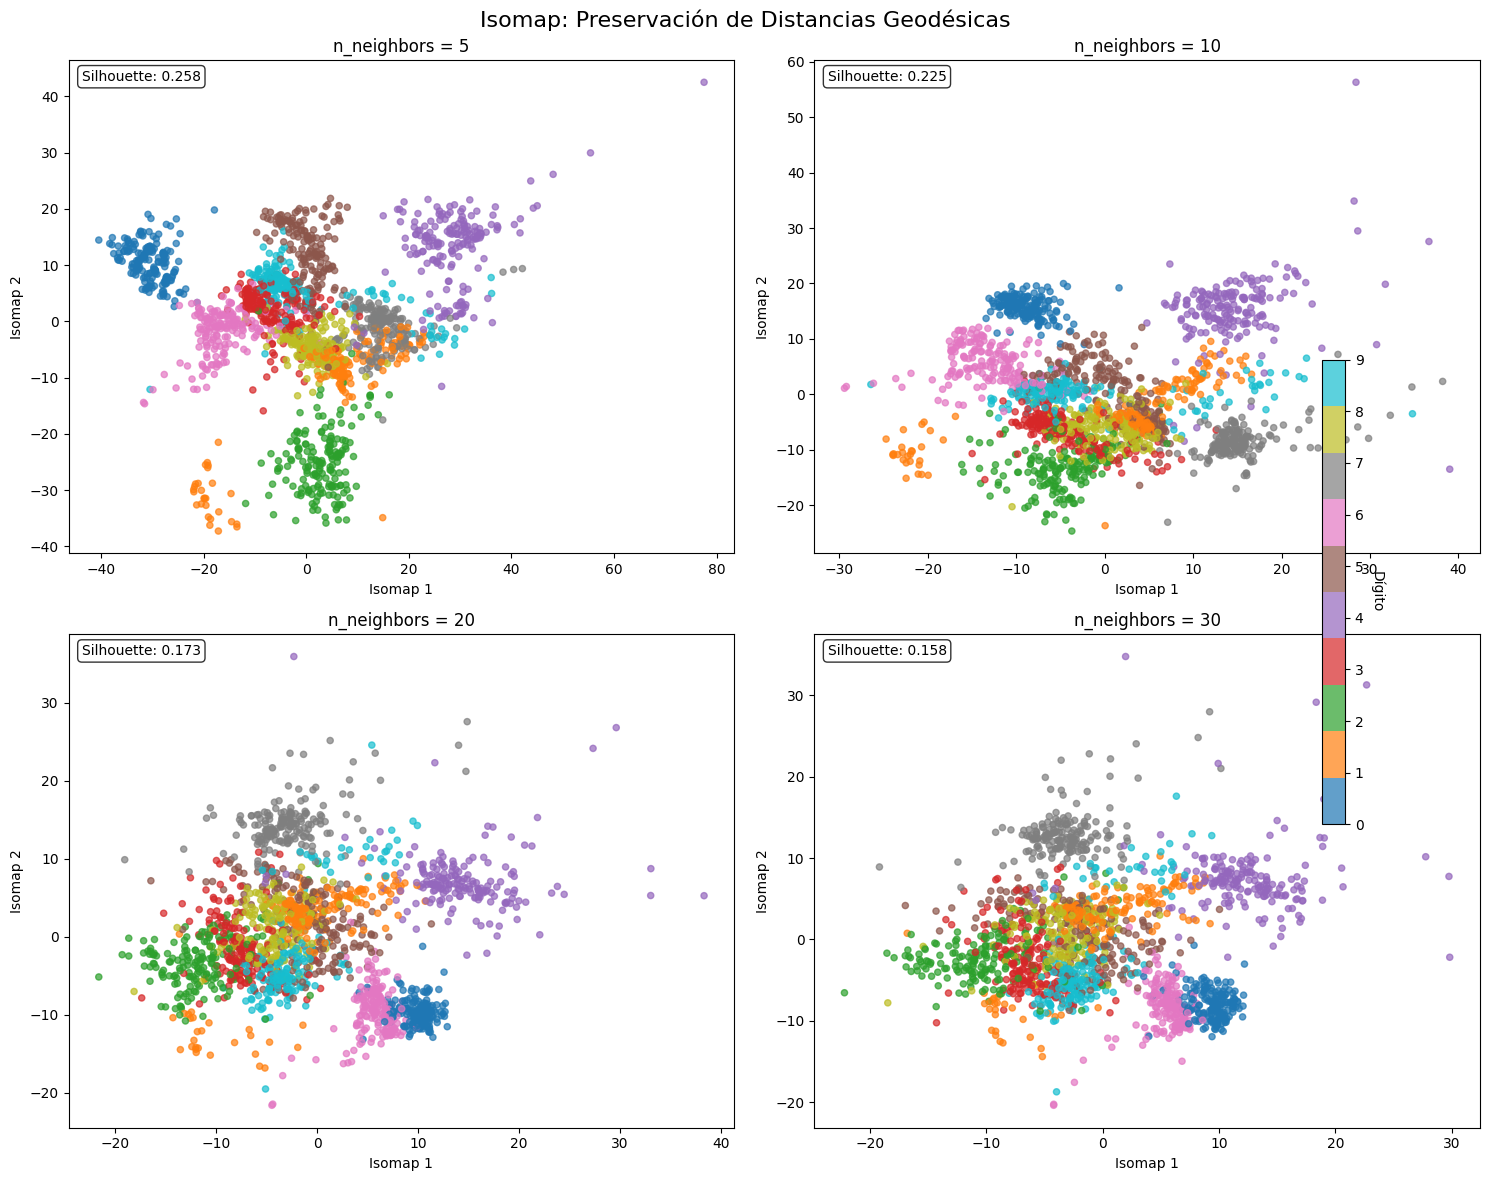

In [9]:
# Visualizar resultados de Isomap
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Isomap: Preservación de Distancias Geodésicas', fontsize=16)

for i, n_neigh in enumerate(n_neighbors_iso):
    ax = axes[i//2, i%2]
    
    scatter = ax.scatter(
        isomap_results[n_neigh][:, 0],
        isomap_results[n_neigh][:, 1],
        c=y,
        cmap='tab10',
        s=20,
        alpha=0.7
    )
    
    ax.set_title(f'n_neighbors = {n_neigh}')
    ax.set_xlabel('Isomap 1')
    ax.set_ylabel('Isomap 2')
    
    # Calcular silhouette score
    sil_score = silhouette_score(isomap_results[n_neigh], y)
    ax.text(0.02, 0.98, f'Silhouette: {sil_score:.3f}', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Agregar colorbar
cbar = plt.colorbar(scatter, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Dígito', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

## 4. PHATE (Potential of Heat-diffusion for Affinity-based Transition Embedding)

### Concepto Clave:
- Basado en **difusión de calor** en grafos
- Preserva tanto estructura local como **transiciones suaves**
- Especialmente bueno para datos con estructura de trayectorias
- Captura la geometría intrínseca de los datos

### Parámetros importantes:
- **k**: número de vecinos para construir el grafo
- **a**: parámetro de escala para el kernel
- **t**: tiempo de difusión

In [10]:
# Aplicar PHATE con diferentes parámetros
k_values = [5, 15, 25, 35]
phate_results = {}

print("Aplicando PHATE con diferentes valores de k...")
for k in tqdm(k_values):
    phate_op = phate.PHATE(
        k=k,
        a=15,
        t='auto',
        n_components=2,
        random_state=42
    )
    phate_results[k] = phate_op.fit_transform(X_scaled)

print("¡Completado!")

Aplicando PHATE con diferentes valores de k...


  0%|          | 0/4 [00:00<?, ?it/s]

Calculating PHATE...
  Running PHATE on 1797 observations and 64 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
  Running PHATE on 1797 observations and 64 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.05 seconds.
    Calculating affinities...
    Calculated KNN search in 0.05 seconds.
    Calculating affinities...
    Calculated affinities in 1.37 seconds.
  Calculated graph and diffusion operator in 1.43 seconds.
  Calculating optimal t...
    Calculated affinities in 1.37 seconds.
  Calculated graph and diffusion operator in 1.43 seconds.
  Calculating optimal t...
    Automatically selected t = 10
  Calculated optimal t in 2.88 seconds.
  Calculating diffusion potential...
    Automatically selected t = 10
  Calculated optimal t in 2.88 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.51 seconds.
  Calculating metric MDS...
  Calculated 

 25%|██▌       | 1/4 [00:09<00:28,  9.59s/it]

Calculating PHATE...
  Running PHATE on 1797 observations and 64 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
  Running PHATE on 1797 observations and 64 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.04 seconds.
    Calculating affinities...
    Calculated KNN search in 0.04 seconds.
    Calculating affinities...
    Calculated affinities in 0.04 seconds.
  Calculated graph and diffusion operator in 0.10 seconds.
    Calculated affinities in 0.04 seconds.
  Calculated graph and diffusion operator in 0.10 seconds.
  Calculating optimal t...
  Calculating optimal t...
    Automatically selected t = 17
  Calculated optimal t in 3.10 seconds.
  Calculating diffusion potential...
    Automatically selected t = 17
  Calculated optimal t in 3.10 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.48 seconds.
  Calculating metric MDS...
  Calculated 

 50%|█████     | 2/4 [00:17<00:17,  8.65s/it]

Calculating PHATE...
  Running PHATE on 1797 observations and 64 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
  Running PHATE on 1797 observations and 64 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.07 seconds.
    Calculating affinities...
    Calculated KNN search in 0.07 seconds.
    Calculating affinities...
    Calculated affinities in 0.05 seconds.
    Calculated affinities in 0.05 seconds.
  Calculated graph and diffusion operator in 0.13 seconds.
  Calculating optimal t...
  Calculated graph and diffusion operator in 0.13 seconds.
  Calculating optimal t...
    Automatically selected t = 25
  Calculated optimal t in 2.16 seconds.
  Calculating diffusion potential...
    Automatically selected t = 25
  Calculated optimal t in 2.16 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.59 seconds.
  Calculating metric MDS...
  Calculated 

 75%|███████▌  | 3/4 [00:24<00:07,  7.87s/it]

Calculating PHATE...
  Running PHATE on 1797 observations and 64 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
  Running PHATE on 1797 observations and 64 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.07 seconds.
    Calculating affinities...
    Calculated KNN search in 0.07 seconds.
    Calculating affinities...
    Calculated affinities in 0.05 seconds.
    Calculated affinities in 0.05 seconds.
  Calculated graph and diffusion operator in 0.14 seconds.
  Calculated graph and diffusion operator in 0.14 seconds.
  Calculating optimal t...
  Calculating optimal t...
    Automatically selected t = 31
  Calculated optimal t in 1.95 seconds.
  Calculating diffusion potential...
    Automatically selected t = 31
  Calculated optimal t in 1.95 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.60 seconds.
  Calculating metric MDS...
  Calculated 

100%|██████████| 4/4 [00:31<00:00,  7.81s/it]

¡Completado!


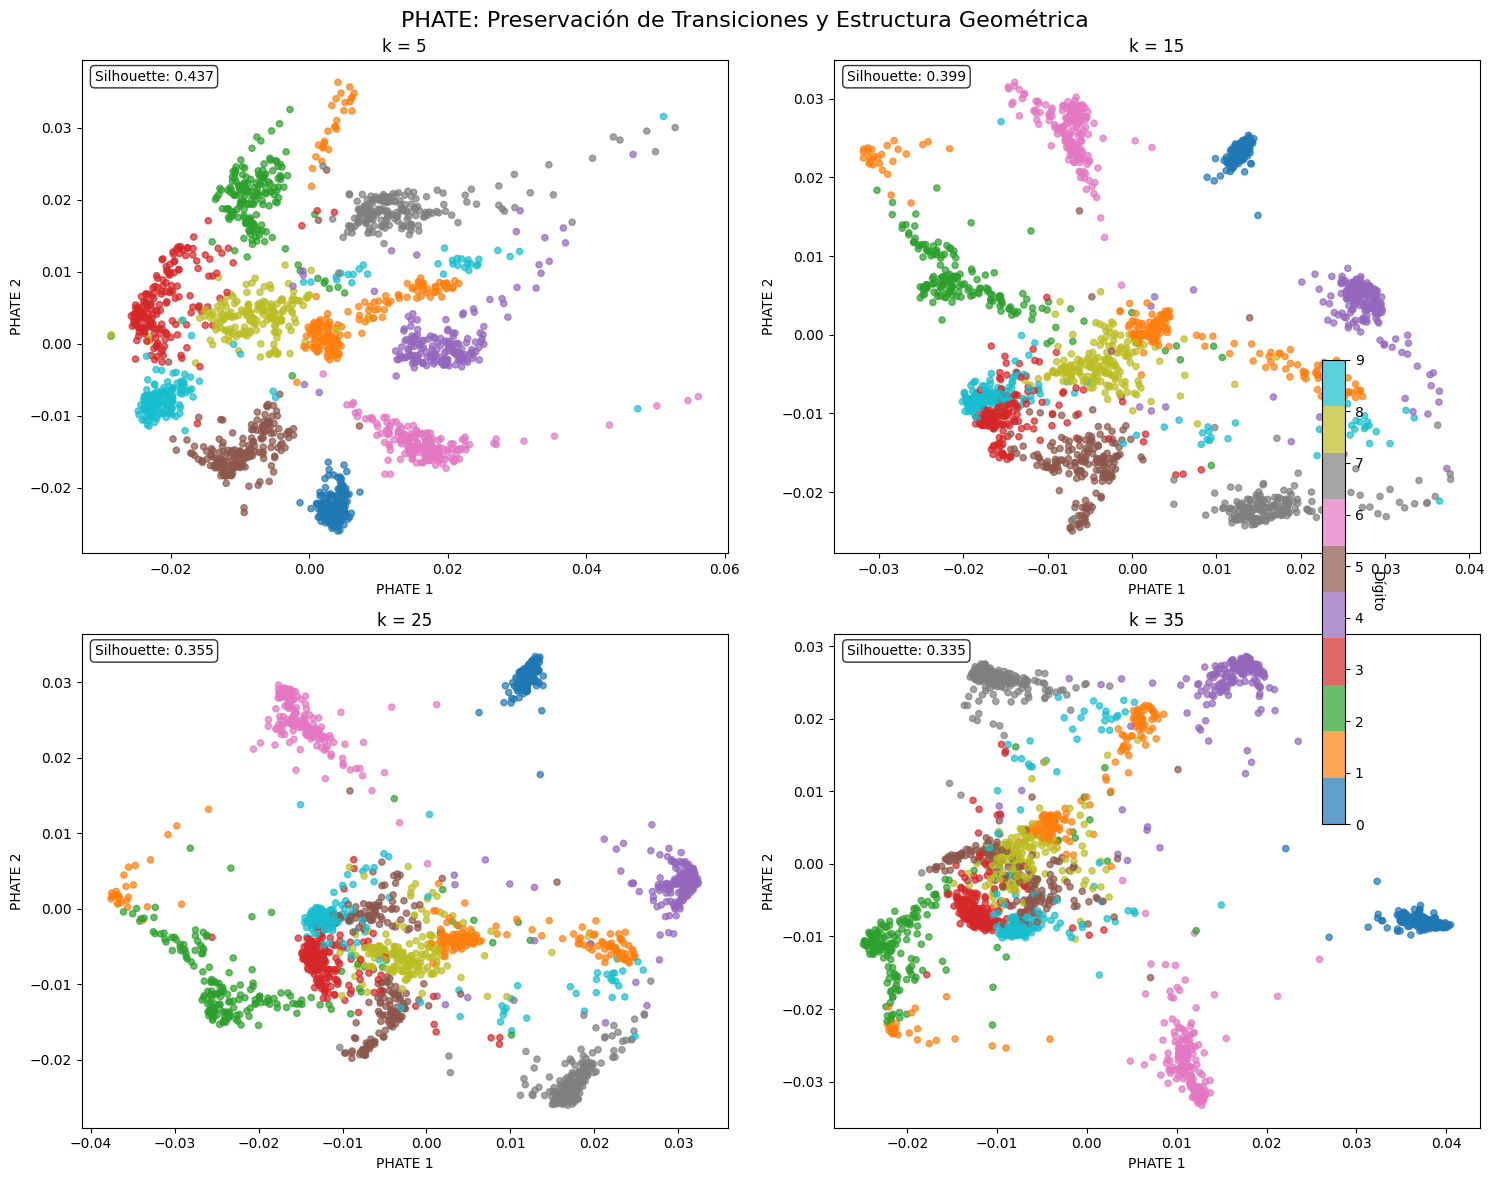

In [11]:
# Visualizar resultados de PHATE
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('PHATE: Preservación de Transiciones y Estructura Geométrica', fontsize=16)

for i, k in enumerate(k_values):
    ax = axes[i//2, i%2]
    
    scatter = ax.scatter(
        phate_results[k][:, 0],
        phate_results[k][:, 1],
        c=y,
        cmap='tab10',
        s=20,
        alpha=0.7
    )
    
    ax.set_title(f'k = {k}')
    ax.set_xlabel('PHATE 1')
    ax.set_ylabel('PHATE 2')
    
    # Calcular silhouette score
    sil_score = silhouette_score(phate_results[k], y)
    ax.text(0.02, 0.98, f'Silhouette: {sil_score:.3f}', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Agregar colorbar
cbar = plt.colorbar(scatter, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Dígito', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

## Comparación Directa de las Cuatro Técnicas

Vamos a comparar las cuatro técnicas usando sus mejores parámetros para entender mejor sus diferencias en la preservación topológica.

In [17]:
# Importar KMeans primero
from sklearn.cluster import KMeans

# Seleccionar los mejores resultados de cada técnica
# (basado en silhouette score y interpretabilidad visual)
best_tsne = tsne_results[30]  # perplexity = 30
best_umap = umap_results[15]  # n_neighbors = 15
best_isomap = isomap_results[10]  # n_neighbors = 10
best_phate = phate_results[15]  # k = 15

# Calcular métricas para comparación
techniques = {
    't-SNE': best_tsne,
    'UMAP': best_umap,
    'Isomap': best_isomap,
    'PHATE': best_phate
}

metrics_df = pd.DataFrame({
    'Técnica': list(techniques.keys()),
    'Silhouette Score': [silhouette_score(emb, y) for emb in techniques.values()],
    'ARI Score': [adjusted_rand_score(y, 
                                     KMeans(n_clusters=10, random_state=42).fit_predict(emb)) 
                  for emb in techniques.values()]
})

print("Métricas de Calidad por Técnica:")
print(metrics_df.round(3))

Métricas de Calidad por Técnica:
  Técnica  Silhouette Score  ARI Score
0   t-SNE             0.477      0.781
1    UMAP             0.575      0.861
2  Isomap             0.225      0.525
3   PHATE             0.399      0.684


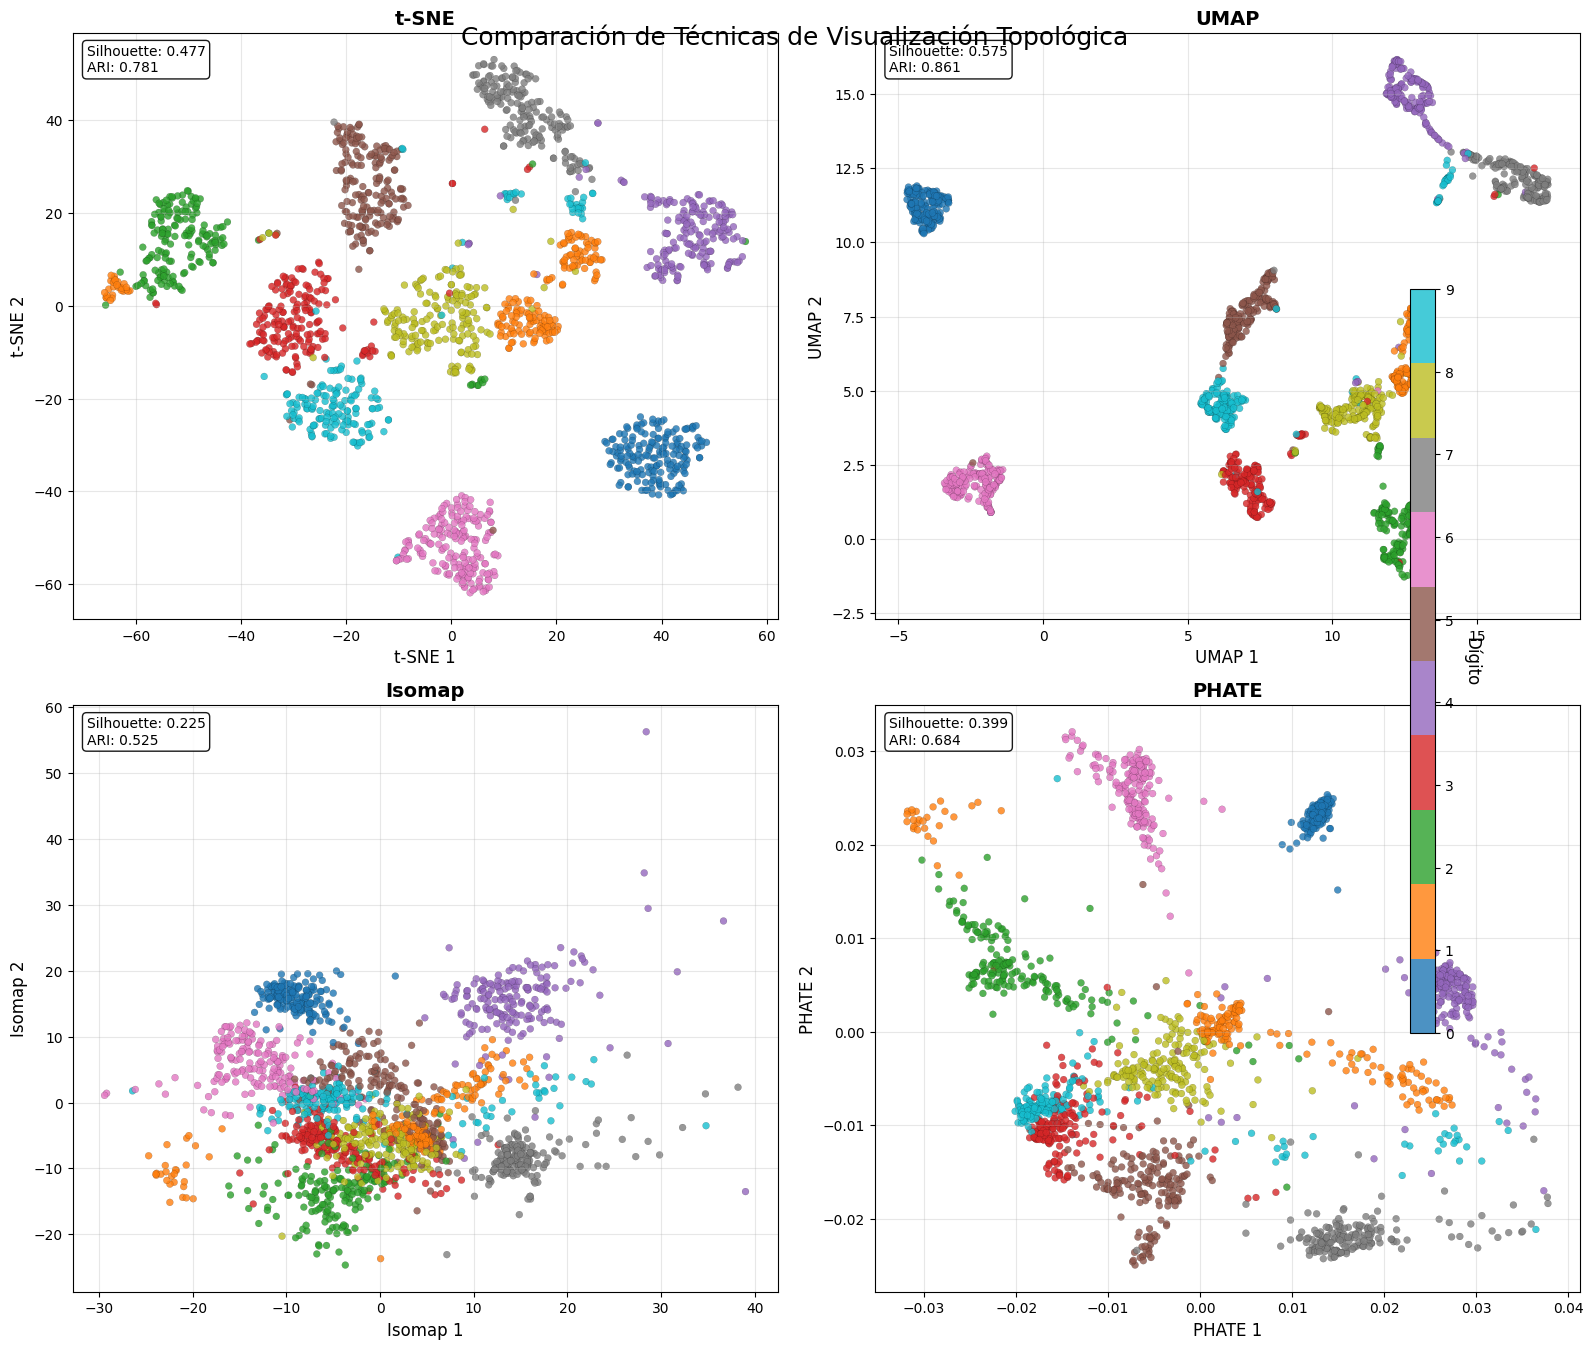

In [18]:
# Visualización comparativa
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle('Comparación de Técnicas de Visualización Topológica', fontsize=18, y=0.95)

techniques_list = [(best_tsne, 't-SNE'), (best_umap, 'UMAP'), 
                   (best_isomap, 'Isomap'), (best_phate, 'PHATE')]

for i, (embedding, name) in enumerate(techniques_list):
    ax = axes[i//2, i%2]
    
    scatter = ax.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=y,
        cmap='tab10',
        s=25,
        alpha=0.8,
        edgecolors='black',
        linewidths=0.1
    )
    
    ax.set_title(f'{name}', fontsize=14, fontweight='bold')
    ax.set_xlabel(f'{name} 1', fontsize=12)
    ax.set_ylabel(f'{name} 2', fontsize=12)
    
    # Añadir métricas
    sil_score = silhouette_score(embedding, y)
    ari_score = adjusted_rand_score(y, 
                                   KMeans(n_clusters=10, random_state=42).fit_predict(embedding))
    
    ax.text(0.02, 0.98, f'Silhouette: {sil_score:.3f}\nARI: {ari_score:.3f}', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
            fontsize=10)
    
    ax.grid(True, alpha=0.3)

# Agregar colorbar común
cbar = fig.colorbar(scatter, ax=axes, orientation='vertical', 
                    fraction=0.02, pad=0.04, aspect=30)
cbar.set_label('Dígito', rotation=270, labelpad=20, fontsize=12)
cbar.set_ticks(range(10))

plt.tight_layout()
plt.show()

## Análisis de Preservación de Vecindarios

Una métrica importante en topología de datos es qué tan bien se preservan los vecindarios locales.

t-SNE: 0.570
UMAP: 0.471
Isomap: 0.208
PHATE: 0.288


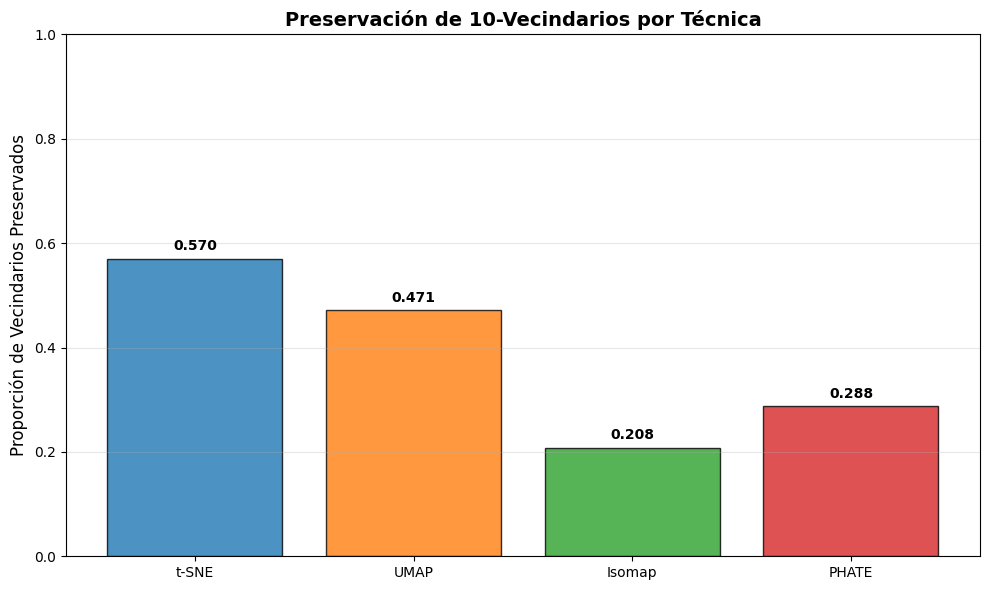

In [19]:
from sklearn.neighbors import NearestNeighbors
from scipy.stats import spearmanr

def neighborhood_preservation(X_original, X_embedded, k=10):
    """
    Calcula qué tan bien se preservan los k-vecinos más cercanos
    """
    # Encontrar k-vecinos en el espacio original
    nbrs_orig = NearestNeighbors(n_neighbors=k+1).fit(X_original)
    _, indices_orig = nbrs_orig.kneighbors(X_original)
    
    # Encontrar k-vecinos en el espacio embedded
    nbrs_emb = NearestNeighbors(n_neighbors=k+1).fit(X_embedded)
    _, indices_emb = nbrs_emb.kneighbors(X_embedded)
    
    # Calcular la preservación promedio de vecindarios
    preservation_scores = []
    for i in range(len(X_original)):
        # Excluir el punto mismo (índice 0)
        orig_neighbors = set(indices_orig[i][1:])
        emb_neighbors = set(indices_emb[i][1:])
        
        # Calcular intersección
        intersection = len(orig_neighbors.intersection(emb_neighbors))
        preservation = intersection / k
        preservation_scores.append(preservation)
    
    return np.mean(preservation_scores)

# Calcular preservación de vecindarios para cada técnica
k_neighbors = 10
preservation_scores = {}

for name, embedding in techniques.items():
    score = neighborhood_preservation(X_scaled, embedding, k_neighbors)
    preservation_scores[name] = score
    print(f"{name}: {score:.3f}")

# Crear gráfico de barras
plt.figure(figsize=(10, 6))
names = list(preservation_scores.keys())
scores = list(preservation_scores.values())

bars = plt.bar(names, scores, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], 
               alpha=0.8, edgecolor='black', linewidth=1)

plt.title(f'Preservación de {k_neighbors}-Vecindarios por Técnica', fontsize=14, fontweight='bold')
plt.ylabel('Proporción de Vecindarios Preservados', fontsize=12)
plt.ylim(0, 1)
plt.grid(True, alpha=0.3, axis='y')

# Añadir valores en las barras
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Visualización Interactiva con Plotly

Creemos una visualización interactiva para explorar mejor los resultados.

In [20]:
# Crear visualización interactiva comparativa
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=['t-SNE', 'UMAP', 'Isomap', 'PHATE'],
    specs=[[{"type": "scatter"}, {"type": "scatter"}],
           [{"type": "scatter"}, {"type": "scatter"}]]
)

# Colores para cada dígito - usar tab10 que tiene exactamente 10 colores
colors = px.colors.qualitative.Plotly[:10]  # Cambiar a Plotly que tiene más colores

# Datos para cada técnica
embeddings_data = [
    (best_tsne, 't-SNE', 1, 1),
    (best_umap, 'UMAP', 1, 2),
    (best_isomap, 'Isomap', 2, 1),
    (best_phate, 'PHATE', 2, 2)
]

for embedding, name, row, col in embeddings_data:
    for digit in range(10):
        mask = y == digit
        fig.add_trace(
            go.Scatter(
                x=embedding[mask, 0],
                y=embedding[mask, 1],
                mode='markers',
                marker=dict(
                    color=colors[digit],
                    size=4,
                    opacity=0.7,
                    line=dict(width=0.5, color='black')
                ),
                name=f'Dígito {digit}',
                legendgroup=f'digit_{digit}',
                showlegend=(row==1 and col==1),  # Solo mostrar leyenda en el primer subplot
                hovertemplate=f'<b>{name}</b><br>Dígito: {digit}<br>X: %{{x:.2f}}<br>Y: %{{y:.2f}}<extra></extra>'
            ),
            row=row, col=col
        )

# Actualizar layout
fig.update_layout(
    title_text="Comparación Interactiva de Técnicas de Visualización Topológica",
    title_x=0.5,
    height=700,
    showlegend=True,
    legend=dict(
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.02
    )
)

# Actualizar ejes
for i in range(1, 5):
    fig.update_xaxes(title_text=f"Componente 1", row=(i-1)//2+1, col=(i-1)%2+1)
    fig.update_yaxes(title_text=f"Componente 2", row=(i-1)//2+1, col=(i-1)%2+1)

fig.show()

## Tabla Resumen de Características

Creemos una tabla comparativa con las características principales de cada técnica.


TABLA COMPARATIVA: TÉCNICAS DE VISUALIZACIÓN TOPOLÓGICA
Técnica Principio                      Preserva              Velocidad Escalabilidad Parámetro clave Silhouette Score Preservación vecindarios
 t-SNE  Distribuciones de probabilidad      Estructura local  Lenta     Baja          perplexity     0.477            0.570                   
  UMAP           Variedades de Riemann        Local y global Rápida     Alta         n_neighbors     0.575            0.471                   
Isomap           Distancias geodésicas Distancias geodésicas  Media    Media         n_neighbors     0.225            0.208                   
 PHATE               Difusión de calor   Transiciones suaves  Media    Media                   k     0.399            0.288                   


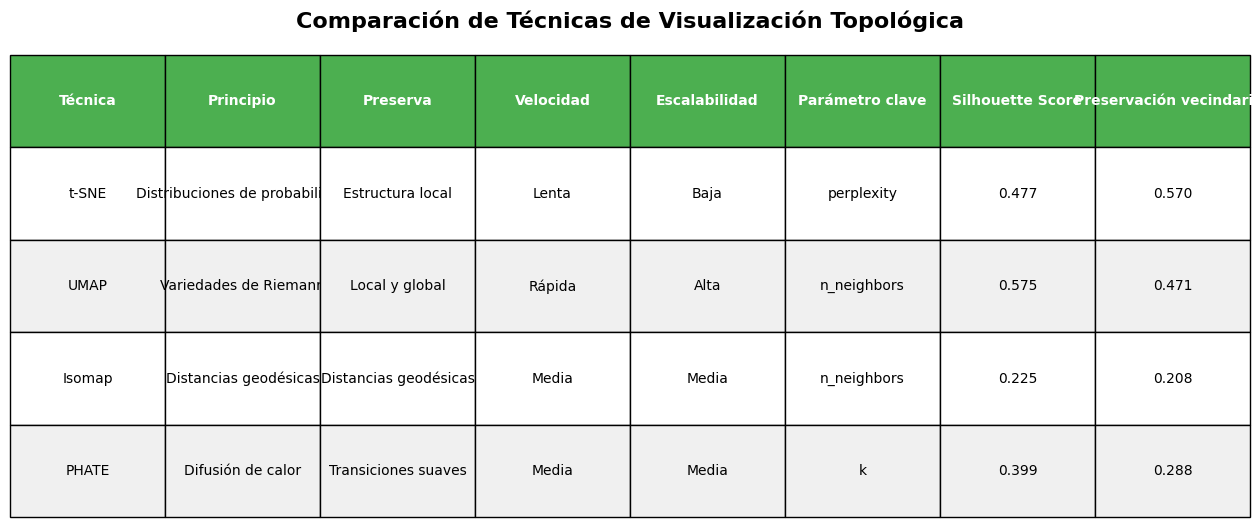

In [21]:
# Crear tabla comparativa
comparison_data = {
    'Técnica': ['t-SNE', 'UMAP', 'Isomap', 'PHATE'],
    'Principio': [
        'Distribuciones de probabilidad',
        'Variedades de Riemann',
        'Distancias geodésicas',
        'Difusión de calor'
    ],
    'Preserva': [
        'Estructura local',
        'Local y global',
        'Distancias geodésicas',
        'Transiciones suaves'
    ],
    'Velocidad': ['Lenta', 'Rápida', 'Media', 'Media'],
    'Escalabilidad': ['Baja', 'Alta', 'Media', 'Media'],
    'Parámetro clave': ['perplexity', 'n_neighbors', 'n_neighbors', 'k'],
    'Silhouette Score': [f"{silhouette_score(emb, y):.3f}" 
                        for emb in [best_tsne, best_umap, best_isomap, best_phate]],
    'Preservación vecindarios': [f"{preservation_scores[name]:.3f}" 
                                for name in ['t-SNE', 'UMAP', 'Isomap', 'PHATE']]
}

comparison_df = pd.DataFrame(comparison_data)

# Mostrar tabla con formato mejorado
print("\n" + "="*100)
print("TABLA COMPARATIVA: TÉCNICAS DE VISUALIZACIÓN TOPOLÓGICA")
print("="*100)
print(comparison_df.to_string(index=False, justify='left'))
print("="*100)

# Crear visualización de la tabla
fig, ax = plt.subplots(figsize=(16, 6))
ax.axis('tight')
ax.axis('off')

table = ax.table(
    cellText=comparison_df.values,
    colLabels=comparison_df.columns,
    cellLoc='center',
    loc='center',
    bbox=[0, 0, 1, 1]
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Colorear header
for i in range(len(comparison_df.columns)):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Colorear filas alternadas
for i in range(1, len(comparison_df) + 1):
    for j in range(len(comparison_df.columns)):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#f0f0f0')

plt.title('Comparación de Técnicas de Visualización Topológica', 
          fontsize=16, fontweight='bold', pad=20)
plt.show()

## Conclusiones y Recomendaciones

### Resumen de Resultados:

1. **t-SNE**:
   - ✅ Excelente para revelar clusters locales
   - ✅ Separación clara entre clases
   - ❌ No preserva estructura global
   - ❌ Lento para datasets grandes

2. **UMAP**:
   - ✅ Balance entre estructura local y global
   - ✅ Rápido y escalable
   - ✅ Mejor preservación topológica general
   - ✅ Parámetros más intuitivos

3. **Isomap**:
   - ✅ Preserva distancias geodésicas
   - ✅ Basado en fundamentos teóricos sólidos
   - ❌ Asume variedad convexa
   - ❌ Sensible a ruido y outliers

4. **PHATE**:
   - ✅ Preserva transiciones suaves
   - ✅ Bueno para datos con estructura de trayectorias
   - ✅ Robusto al ruido
   - ❌ Parámetros menos intuitivos

### Cuándo usar cada técnica:

- **t-SNE**: Análisis exploratorio, visualización de clusters
- **UMAP**: Uso general, datasets grandes, necesidad de preservar estructura global
- **Isomap**: Datos en variedades convexas, cuando las distancias geodésicas son importantes
- **PHATE**: Datos con trayectorias, análisis de transiciones, datos biológicos